In [1]:
from Ocean_01_F_Annotate_Ops_Module import *
print('\nJupyter running Python {}'.format(sys.version_info[0]))

OOI RCA Oregon Slope Base: Shallow Profiler status report
For March 2021:
31 days, translates to 279 possible profiles
Actual:
262 profiles; 29 at local midnight and 30 at local noon

Jupyter running Python 3


In [2]:
D = xr.open_dataset('../../data/rca/fluor/osb/2021/flort_fullres.nc')
D = D.swap_dims({'obs':'time'})
# Save .dropna() until after running the median filter; this preserves more information?
# D = D.dropna('time')
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})
D = D[['chlora', 'fdom', 'backscatter', 'seawater_scattering_coefficient', \
       'practical_salinity', 'seawater_temperature', 'int_ctd_pressure'    ]]
D = D.drop(['obs', 'lat', 'lon'])
D = D.reset_coords()
D.attrs={}
# print(D, D.time[0], D.time[-1])
print('23-JAN-2021 through 14-APR-2021 (both noon Zulu)')

23-JAN-2021 through 14-APR-2021 (both noon Zulu)


In [5]:
data_time_start = dt64(D.time[0].data)
data_time_stop  = dt64(D.time[-1].data)
print('this dataset covers', data_time_start, ' ---through--- ', data_time_stop)

this dataset covers 2021-01-23T12:00:00.228180992  ---through---  2021-04-14T11:59:59.167518208


In [142]:
# p.shape gives 1855 x 6; this code looks for the profile index of the first profile in the dataset
p_index_begin = 0                                     # begin/end refers to the profile data for this year 
p_index_start = p_index_begin                         # start/stop refers to profile indices within this dataset
p_index_end   = p.shape[0]
for i in range(p_index_end):                          # 0 1 2 ... 1854
    this_ascent_start = dt64(p['ascent_start'][i])
    if this_ascent_start > data_time_start:
        p_index_start = i
        print('Start: Compare data begins at', data_time_start, '< first ascent at', this_ascent_start)
        break

for i in range(p_index_start, p_index_end):                         # 180 181 182 ... 1854
    this_descent_end = dt64(p['descent_end'][i])
    if this_descent_end > data_time_stop:                           # as the data runs out before profile [i] does: Back up one profile
        p_index_stop = i - 1
        this_descent_end = dt64(p['descent_end'][p_index_stop])     # adjust to previous profile
        print('Stop: Compare data stops at', data_time_stop, '> stop of last profile at', this_descent_end, ': profile indices run', p_index_start, '...', p_index_stop, '(', str(p_index_stop-p_index_start+1), 'profiles )')
        break        

Start: Compare data begins at 2021-01-23T12:00:00.228180992 < first ascent at 2021-01-23T13:32:00.000000
Stop: Compare data stops at 2021-04-14T11:59:59.167518208 > stop of last profile at 2021-04-14T09:56:00.000000 : profile indices run 180 ... 885 ( 706 profiles )


In [143]:
D

<xarray.Dataset>
Dimensions:                          (time: 5830998)
Coordinates:
  * time                             (time) datetime64[ns] 2021-01-23T12:00:0...
Data variables:
    chlora                           (time) float64 ...
    fdom                             (time) float64 ...
    backscatter                      (time) float64 ...
    seawater_scattering_coefficient  (time) float64 ...
    practical_salinity               (time) float64 ...
    seawater_temperature             (time) float64 ...
    int_ctd_pressure                 (time) float64 ...
    depth                            (time) float64 ...

### To Do / Bugs

- reporting of PType() lags unless you choose points; but seems ok in the CSV
- enable lens mode
- expand capacity for trace to 6 interior points
- get the metadata fields correct
- check globals

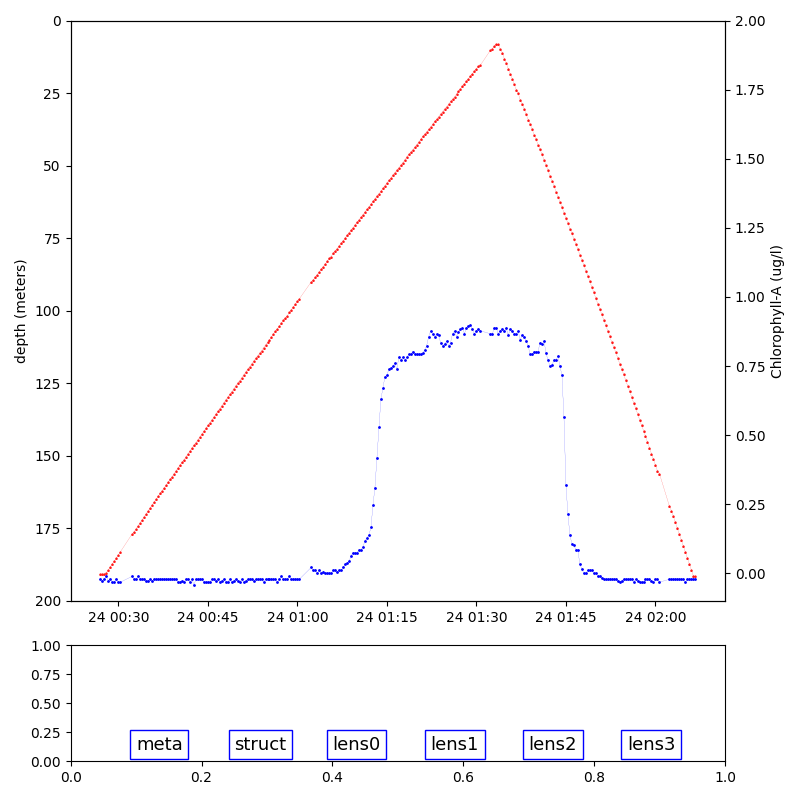

In [145]:
##############
#
# Annotation
#
##############

modes = {0:'meta', 1:'struct', 2:'lens0', 3:'lens1', 4:'lens2', 5:'lens3'}

# p_index_start is 180
p_index_progress = 212
# p_index_stop is 885

# initialize the dataframe and operating modes
columns_metadata = ['index', 'ascent start', 'depth start', 'ascent end', 'depth minimum', 'descent end', 'descent end', 'profile type', 'remark']

remark_index = len(columns_metadata) - 1

columns_structure = [                             \
        't00', 'd00', 'c00', 't01', 'd01', 'c01', \
        't02', 'd02', 'c02', 't03', 'd03', 'c03', \
        't04', 'd04', 'c04', 't05', 'd05', 'c05', \
        't06', 'd06', 'c06', 't07', 'd07', 'c07', \
        't08', 'd08', 'c08', 't09', 'd09', 'c09', \
        't10', 'd10', 'c10', 't11', 'd11', 'c11']


columns_lens0 = ['l0_t00', 'l0_d00', 'l0_c00', 'l0_t01', 'l0_d01', 'l0_c01', 'l0_t02', 'l0_d02', 'l0_c02', 'l0_t03', 'l0_d03', 'l0_c03']
columns_lens1 = ['l1_t00', 'l1_d00', 'l1_c00', 'l1_t01', 'l1_d01', 'l1_c01', 'l1_t02', 'l1_d02', 'l1_c02', 'l1_t03', 'l1_d03', 'l1_c03']
columns_lens2 = ['l2_t00', 'l2_d00', 'l2_c00', 'l2_t01', 'l2_d01', 'l2_c01', 'l2_t02', 'l2_d02', 'l2_c02', 'l2_t03', 'l2_d03', 'l2_c03']
columns_lens3 = ['l3_t00', 'l3_d00', 'l3_c00', 'l3_t01', 'l3_d01', 'l3_c01', 'l3_t02', 'l3_d02', 'l3_c02', 'l3_t03', 'l3_d03', 'l3_c03']


df = pd.DataFrame(columns = columns_metadata + columns_structure + columns_lens0 + columns_lens1 + columns_lens2 + columns_lens3)
p_metadata  = ['']*len(columns_metadata)
p_structure = ['']*len(columns_structure)
p_lens0     = ['']*len(columns_lens0)
p_lens1     = ['']*len(columns_lens1)
p_lens2     = ['']*len(columns_lens2)
p_lens3     = ['']*len(columns_lens3)

current_mode = 1

mode_meta_capacity   = len(columns_metadata)
mode_struct_capacity = len(columns_structure)//3
mode_lens0_capacity  = len(columns_lens0)//3
mode_lens1_capacity  = len(columns_lens1)//3
mode_lens2_capacity  = len(columns_lens2)//3
mode_lens3_capacity  = len(columns_lens3)//3

def ResetModeIndices():
    global mode_struct_ix, mode_lens0_ix, mode_lens1_ix, mode_lens2_ix, mode_lens3_ix
    mode_struct_ix = -1
    mode_lens0_ix  = -1
    mode_lens1_ix  = -1
    mode_lens2_ix  = -1
    mode_lens3_ix  = -1
    return

ResetModeIndices()

########################
#
# Functions
#
########################

def ClearList(l): 
    for i in range(len(l)): l[i] = ''

def ClearRecord(ll):
    for i in range(len(ll)): ClearList(ll[i])

def PType(peak_time):
    midn0 = dt64(str(peak_time)[:11] + '08:00')
    midn1 = dt64(str(peak_time)[:11] + '09:00')
    noon0 = dt64(str(peak_time)[:11] + '21:10')
    noon1 = dt64(str(peak_time)[:11] + '22:10')
    if  peak_time > midn0 and peak_time < midn1: return 'midn'
    if  peak_time > noon0 and peak_time < noon1: return 'noon'
    return 'quot'

###########
#
# Chlor A bias
# 
###########


chla_bias = -.0321


##################
#
# chart and event handler
#
##################

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import sleep

####################
#
# mouse event (click event)
#
####################

def mouse_event(event):
    
    global D, D_this, D_this_median
    global p, p_index_this, p_index_stop
    global data                                                               # ? really ?
    global modes, current_mode, mode_struct_capacity, mode_lens_capacity
    global mode_meta_ix, mode_struct_ix, mode_lens0_ix, mode_lens1_ix, mode_lens2_ix, mode_lens3_ix
    global mode_meta_capacity, mode_struct_capacity, mode_lens0_capacity, mode_lens1_capacity, mode_lens2_capacity, mode_lens3_capacity
    global text_axs1_1, text_axs1_2
    global t0_this, tm_this, t1_this

    
    msg1 = 'mode: ' + modes[current_mode]
    msg1 = msg1 + ';  profile type: ' + PType(tm_this)
    msg1 = msg1 + '   start: ' + str(p['ascent_start'][p_index_this])[:13] + '    '

    
    # click in main chart
    if str(event.inaxes)[23:28] == '.2486':           # axs[0]
        
        if current_mode == 0:
            p_metadata[remark_index] = input('Remark: ')
            
        elif current_mode == 1:
            struct_msg = '1' if mode_struct_ix == -1 else str((mode_struct_ix + 1) % mode_struct_capacity + 1)
            msg1 = msg1 + struct_msg + '/' + str(mode_struct_capacity) + '  '
            msg1 = msg1 + str(mode_lens0_ix + 1)  + '/' + str(mode_lens0_capacity)  + '  '
            msg1 = msg1 + str(mode_lens1_ix + 1)  + '/' + str(mode_lens1_capacity)  + '  '
            msg1 = msg1 + str(mode_lens2_ix + 1)  + '/' + str(mode_lens2_capacity)  + '  '
            msg1 = msg1 + str(mode_lens3_ix + 1)  + '/' + str(mode_lens3_capacity)

            this_date_str = str(mdates.num2date(event.xdata))
            this_date     = dt64(this_date_str[:19])
            this_y        = round(event.ydata, 3)
            data          = D_this_median.sel(time=this_date, method="nearest")
            data_dt64     = str(data.time.data)[:19]
            data_chla     = str(round(float(data.chlora) - chla_bias, 4))
            data_depth    = str(round(float(data.depth), 3))
            msg2          = data_chla + '    ' + data_depth + '    ' + data_dt64

            # Add this click to struct or lensX depending on mode
            # struct only for now
            mode_struct_ix += 1
            if mode_struct_ix == mode_struct_capacity:
                mode_struct_ix = 0
                ClearList(p_structure)
            p_structure[3*mode_struct_ix]     = data_dt64
            p_structure[3*mode_struct_ix + 1] = data_depth
            p_structure[3*mode_struct_ix + 2] = data_chla
            
        else:
            a = 0  # dummy; this is lenses
            
    # the click was in the control chart
    else:
        # lower 1/4 is mode select
        if event.ydata < 0.25:
            xloc = event.xdata
            if xloc < 0.2: p_metadata[remark_index] = input('Remark: ')
            else:          current_mode = 1
            
        # upper 3/4 is the 'next profile' command
        else: 
            # finish and save the about-to-be-prior profile's information...
            # fill in the metadata
            p_metadata[0] = str(p_index_this)
            # p_metadata[1] = str(t0_this)
            p_metadata[2] = '200'
            # p_metadata[3] = str(tm_this)
            p_metadata[4] = '10'
            # p_metadata[5] = str(t1_this)
            p_metadata[6] = '200'
            p_metadata[7] = PType(tm_this)

            df.loc[len(df.index)] = p_metadata + p_structure + p_lens0 + p_lens1 + p_lens2 + p_lens3
            df.to_csv('./chla_annotate.csv')
            ClearRecord([p_metadata, p_structure, p_lens0, p_lens1, p_lens2, p_lens3])
            ResetModeIndices()

            p_index_this += 1
            mode_struct_ix = -1
            
            # either halt...
            if p_index_this > p_index_stop: 
                msg1 = 'all done with profiles'
                msg2 = '   ...ah reckon'

            # ...or load the next profile
            else:
                t0_this       = p['ascent_start'][p_index_this]
                tm_this       = p['ascent_end'][p_index_this]
                t1_this       = p['descent_end'][p_index_this]    

                D_this        = D.sel(time=slice(t0_this, t1_this))
                D_this_median = D_this.resample(time='20S').median().dropna('time')
                

                axtwinChlA.clear()
                axtwinChlA.set(ylim = (-.1, 2.0), ylabel='Chlorophyll-A (ug/l)')
                axtwinChlA.plot(D_this_median.time, D_this_median.chlora, ms = 2., marker='.', linewidth=.1, color='b')

                axs[0].clear()
                axs[0].set(ylim = (200., 0.), ylabel='depth (meters)')
                axs[0].plot(D_this_median.time, D_this_median.depth,  ms = 1., marker='^', linewidth=.1, color='r')

                fig.canvas.draw()
    
    text_axs1_1 = axs[1].text(0.05, .75, msg1, color='k', fontsize=10)
    text_axs1_1.set_bbox(bbd1)
    text_axs1_2 = axs[1].text(0.05, .50, msg2, color='r', fontsize=10)
    text_axs1_2.set_bbox(bbd2)
    
    fig.canvas.draw()
    # fig.canvas.flush_events()
    # plt.show()



###############
#
# profile indexing
#
###############

p_index_this = p_index_progress

#################
#
# chart
#
#################

plt.rcParams["figure.autolayout"] = True
fig,axs = plt.subplots(2, figsize=(8,8), gridspec_kw={'height_ratios': [5,1]})
fig.canvas.mpl_connect('button_press_event', mouse_event)
# axtwinFDOM = axs[0].twinx()
# axtwinBB7C = axs[0].twinx()
axtwinChlA = axs[0].twinx()

t0_this = p['ascent_start'][p_index_this]
tm_this = p['ascent_end'][p_index_this]
t1_this = p['descent_end'][p_index_this]  
D_this        = D.sel(time=slice(t0_this, t1_this))
D_this_median = D_this.resample(time='20S').median().dropna('time')
    
# set up the depth plot
axtwinChlA.set(ylim = (-.1, 2.0), ylabel='Chlorophyll-A (ug/l)')
axtwinChlA.plot(D_this_median.time, D_this_median.chlora, ms = 2., marker='.', linewidth=.1, color='b')

axs[0].set(ylim = (200., 0.), ylabel='depth (meters)')
axs[0].plot(D_this_median.time, D_this_median.depth,  ms = 1., marker='^', linewidth=.1, color='r')

bbd1 = dict(facecolor='white', alpha=1.0, edgecolor='b')
bbd2 = dict(facecolor='white', alpha=1.0, edgecolor='magenta')

modebox = [axs[1].text(0.1 + 0.15*i, .10, modes[i], color='k', fontsize = 13) for i in range(6)]
for i in range(6): modebox[i].set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='blue'))

plt.show()




21:48
08:26
21:42
08:25
21:41
08:27
21:35
08:16
21:44
08:26
21:50
08:30




pandas._libs.tslibs.timestamps.Timestamp

In [134]:
if dt64(p['ascent_end'][5]) > dt64(str(dxxx)[:11] + '08:00') and dt64(p['ascent_end'][5]) < dt64(str(dxxx)[:11] + '09:00'): print('between')

In [118]:
date.year[0]

2021

In [135]:
tm_this

Timestamp('2021-03-14 14:37:00')

In [137]:
# if dt64(tm_this) > dt64(str(tm_this)[:11] + '08:00') and dt64(tm_this) < dt64(str(tm_this)[:11] + '15:00'): print('between')
if tm_this > dt64(str(tm_this)[:11] + '08:00') and tm_this < dt64(str(tm_this)[:11] + '15:00'): print('between')


between


In [89]:
pd.to_datetime(p['ascent_end'][5]).time

<function Timestamp.time>

In [97]:
dir(this_dt)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_interface__',
 '__array_priority__',
 '__array_struct__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__xor__',
 'all',
 'any',
 'argmax',
 'argmin',
 'argsort',
 'ast

In [77]:
D_this_median

<xarray.Dataset>
Dimensions:                                 (time: 305)
Coordinates:
  * time                                    (time) datetime64[ns] 2021-01-23T...
Data variables: (12/13)
    chlora                                  (time) float64 -0.0107 ... -0.0214
    fdom                                    (time) float64 1.3 1.3 ... 1.3 1.3
    backscatter                             (time) float64 0.0007566 ... 0.00...
    seawater_scattering_coefficient         (time) float64 0.0006402 ... 0.00...
    practical_salinity                      (time) float64 33.92 33.92 ... 33.92
    seawater_temperature                    (time) float64 7.482 7.483 ... 7.525
    ...                                      ...
    fluorometric_chlorophyll_a_qc_executed  (time) float64 29.0 29.0 ... 29.0
    optical_backscatter_qc_executed         (time) float64 29.0 29.0 ... 29.0
    fluorometric_cdom_qc_executed           (time) float64 29.0 29.0 ... 29.0
    fluorometric_chlorophyll_a_qc_results   (time) float64 12.0 12.5 ... 12.0
    optical_backscatter_qc_results          (time) float64 13.0 13.0 ... 13.0
    fluorometric_cdom_qc_results            (time) float64 29.0 29.0 ... 29.0

In [23]:
t=dt64(locations[0][0][:16])
t

numpy.datetime64('2021-01-23T14:01')

In [ ]:
dmsg

In [27]:
msg = input('ho')
msg

ho what do you think


'what do you think'

In [ ]:
dir(event.ydata)

In [10]:
axs[0].order

AttributeError: 'AxesSubplot' object has no attribute 'swapaxes'

In [137]:
# initialize the dataframe
cols = ['index', 'ascent start', 'descent end', \
        't00', 'd00', 'c00', 't01', 'd01', 'c01', \
        't02', 'd02', 'c02', 't03', 'd03', 'c03', \
        't04', 'd04', 'c04', 't05', 'd05', 'c05', \
        't06', 'd06', 'c06', 't07', 'd07', 'c07']
df = pd.DataFrame(columns=cols) 
display(df)
df.loc[len(df.index)] = [1, 'jan 01', 'jan 02', \
                         '1:00', '40', '1.1',   \
                         '1:01', '30', '2.1',   \
                         '1:02', '20', '3.1',   \
                         '', '', '', '', '', '', '', '', '', '', '', '', '', '', '' ]
display(df)

,index,ascent start,descent end,t00,d00,c00,t01,d01,c01,t02,...,c04,t05,d05,c05,t06,d06,c06,t07,d07,c07


,index,ascent start,descent end,t00,d00,c00,t01,d01,c01,t02,...,c04,t05,d05,c05,t06,d06,c06,t07,d07,c07
0,1,jan 01,jan 02,1:00,40,1.1,1:01,30,2.1,1:02,...,,,,,,,,,,
